# Simple hybrid system
## Case 3
To evaluate the complete method, we now add two simple linear models mod_1 and mod_2 considering the example $\xi = (0.6, 0.48, 0.1)$.

In [1]:
import json
import numpy as np
import pandas as pd
import warnings
import shap
import lime.lime_tabular
import sys
from sklearn import linear_model

warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
sys.path.append('C:/Users/gianl/OneDrive/Desktop/Progs/SMACE/')

In [3]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace.models import Model
from smace import utils

The input data is a random sample of three uniform variables $x_1$, $x_2$ and $x_3$ in $[0,1]$.

In [4]:
# input data
data = np.random.rand(1000, 3)
df = pd.DataFrame(data, columns=['x1', 'x2', 'x3'])
df.head()

,x1,x2,x3
0,0.417022,0.720324,0.000114
1,0.302333,0.146756,0.092339
2,0.186260,0.345561,0.396767
3,0.538817,0.419195,0.685220
4,0.204452,0.878117,0.027388


In [5]:
# decision rules
with open('rule_case1.json', 'r') as fp:
    rules_json = json.load(fp)

In [6]:
# models
def f_1(x):
    return 1 * x[:, 1] + 2 * x[:, 2]
print('Model 1: 1*x2 + 2*x3')

def f_2(x):
    return - 500 * x[:, 1] + 1000 * x[:, 2]
print('Model 2: - 500*x2 + 1000*x3')

X = df.values
y1 = f_1(X)
y2 = f_2(X)

reg1 = linear_model.LinearRegression()
reg1.fit(X,y1)

reg2 = linear_model.LinearRegression()
reg2.fit(X,y2)

model_1 = Model(reg1.predict, 'mod_1', df)
model_2 = Model(reg2.predict, 'mod_2', df)

models_list = [model_1, model_2]

Model 1: 1*x2 + 2*x3
Model 2: - 500*x2 + 1000*x3


In [7]:
# decision system
dm = DM(rules_json, models_list, df)  

In [8]:
# Initialize the explainers
explainer = Smace(dm)
data_summary = shap.sample(df, 100)
shap_explainer = shap.KernelExplainer(dm.make_decision_eval, data_summary)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(df.values, feature_names=df.columns,
                                                        discretize_continuous=True, verbose=False,
                                                        mode='classification',
                                                        )

In [9]:
dm.rules['mod'].labels

['x1 <= 0.5', 'x2 >= 0.6', 'x3 >= 0.25', 'mod_1 >= 1', 'mod_2 <= 600']

In [10]:
example = np.array([0.6, 0.48, 0.1])
print(example)

[0.6  0.48 0.1 ]


In [11]:
print('Model 1 predicts: ', str(model_1.predict(example)))
print('Model 2 predicts: ', str(model_2.predict(example)))

Model 1 predicts:  [0.68]
Model 2 predicts:  [-140.]


Not all conditions are met.

Let us start by applying SHAP to explain the models.

In [12]:
print('Model 1')
print('True value x1: 0*(x1-E[x1])', 0*(example[0]-df.x1.mean()) / model_1.predict(df).std())
print('True value x2: 1.5*(x2-E[x2])', 1.5*(example[1]-df.x2.mean()) / model_1.predict(df).std())
print('True value x3: 2*(x3-E[x3])', 2*(example[2]-df.x3.mean()) / model_1.predict(df).std())

phi_1 = explainer.explain_model(example, model_1, verbose=True)

Model 1
True value x1: 0*(x1-E[x1]) 0.0
True value x2: 1.5*(x2-E[x2]) -0.0662539490010366
True value x3: 2*(x3-E[x3]) -1.2513002807242843
-Contributions to model mod_1:
    Contribution
x3     -1.256971
x2     -0.097357
x1      0.000000


In [13]:
print('Model 2')
print('True value x1: 0*(x1-E[x1])', 0*(example[0]-df.x1.mean()) / model_2.predict(df).std())
print('True value x2: -500*(x2-E[x2])', -500*(example[1]-df.x2.mean()) / model_2.predict(df).std())
print('True value x3: 1000*(x3-E[x3])', 1000*(example[2]-df.x3.mean()) / model_2.predict(df).std())

phi_2 = explainer.explain_model(example, model_2, verbose=True)

Model 2
True value x1: 0*(x1-E[x1]) 0.0
True value x2: -500*(x2-E[x2]) 0.043140916656214376
True value x3: 1000*(x3-E[x3]) -1.2221665712736474
-Contributions to model mod_2:
    Contribution
x3     -1.227705
x2      0.095090
x1      0.000000


We now get the explanation for the rule.

In [14]:
r = explainer.explain_rules(example, ['mod'], verbose=True)


> Decision: NO True
Rule: mod
['x1 <= 0.5', 'x2 >= 0.6', 'x3 >= 0.25', 'mod_1 >= 1', 'mod_2 <= 600']
-Contributions to rule-based decision:
       Contribution
x1           -0.900
mod_1        -0.889
x2           -0.880
x3           -0.850
mod_2         0.496


Finally, the aggregation project the contribution on input features.
Let us compare our results with SHAP and LIME.

In [15]:
e = explainer.explain(example, 'mod')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.900000,-0.047,-0.179
x2,-0.746285,-0.047,-0.173
x3,-0.341495,-0.047,-0.175


<AxesSubplot:>

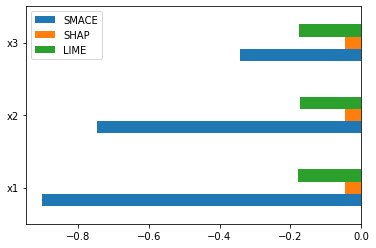

In [16]:
res.plot.barh()

In [17]:
# Anchors
from anchor import anchor_tabular
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x3 <= 0.25
Precision: 1.00
Coverage: 0.24
